In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np

#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score

# we are using the scipy implementation
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.cluster import KMeans

%pylab inline

import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sch

from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


In [25]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

# The purpose of this notebook is to add as many features as we can imagine and see which ones are the most relevant

In [26]:
train = pd.read_csv('data/train_clean.csv')

## Transform attributes in numeric values

In [27]:
train.columns

Index([u'CUST_COD', u'LIMIT_BAL', u'SEX', u'EDUCATION', u'MARRIAGE',
       u'BIRTH_DATE', u'PAY_DEC', u'PAY_NOV', u'PAY_OCT', u'PAY_SEP',
       u'PAY_AUG', u'PAY_JUL', u'BILL_AMT_DEC', u'BILL_AMT_NOV',
       u'BILL_AMT_OCT', u'BILL_AMT_SEP', u'BILL_AMT_AUG', u'BILL_AMT_JUL',
       u'PAY_AMT_DEC', u'PAY_AMT_NOV', u'PAY_AMT_OCT', u'PAY_AMT_SEP',
       u'PAY_AMT_AUG', u'PAY_AMT_JUL', u'DEFAULT PAYMENT JAN'],
      dtype='object')

### Drop CUST_COD

We won't use it, at the moment

In [28]:
train = train.drop(['CUST_COD'], axis=1)

## Transform SEX

In [29]:
train['SEX_MISSING'] = train['SEX'].isnull()*1      # Add a column to say if sex was missing or not
train.loc[train['SEX'].isnull(), 'SEX'] = 'F' # Predict sex with majority class
train['SEX'] = train['SEX'].apply(lambda x : 0 if x == 'M' else 1)   # Convert to M -> 0, F -> 1

## Transform EDUCATION

In [30]:
train['EDUCATION_MISSING'] = train['EDUCATION'].isnull() * 1 # Add a column to say if education was missing or not
train['EDUCATION'] = train['EDUCATION'].fillna('other')    # Predict missing values as other

train = pd.get_dummies(train, columns=['EDUCATION'])   # Get one hot vector for education

## Trasform MARRIAGE

In [31]:
train['MARRIAGE_MISSING'] = train['MARRIAGE'].isnull() * 1 # Add a column to say if education was missing or not
train['MARRIAGE'] = train['MARRIAGE'].fillna('other')    # Predict missing values as other
train = pd.get_dummies(train, columns=['MARRIAGE'])   # Get one hot vector for education

## Transform BIRTH_DATE

In [32]:
train['AGE_MISSING'] = train['BIRTH_DATE'].isnull() * 1

In [33]:
import datetime

birthdates = train['BIRTH_DATE']

def get_age(date):
    try:
        return (datetime.datetime.today() - datetime.datetime.strptime(date, '%d/%m/%Y')).days//365
    except Exception as e:
        return date

birthdates = birthdates.apply(get_age)

In [34]:
birthdates.describe()

count    26182.000000
mean        36.488160
std          9.201312
min         22.000000
25%         29.000000
50%         35.000000
75%         42.000000
max         76.000000
Name: BIRTH_DATE, dtype: float64

In [35]:
# Fill NA with mean value
birthdates = birthdates.fillna(36)

In [36]:
train['AGE'] = birthdates
train = train.drop(['BIRTH_DATE'], axis=1)

## Transform all columns in float

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26884 entries, 0 to 26883
Data columns (total 33 columns):
LIMIT_BAL                    26884 non-null float64
SEX                          26884 non-null int64
PAY_DEC                      26884 non-null int64
PAY_NOV                      26884 non-null int64
PAY_OCT                      26884 non-null int64
PAY_SEP                      26884 non-null int64
PAY_AUG                      26884 non-null int64
PAY_JUL                      26884 non-null int64
BILL_AMT_DEC                 26884 non-null float64
BILL_AMT_NOV                 26884 non-null float64
BILL_AMT_OCT                 26884 non-null float64
BILL_AMT_SEP                 26884 non-null float64
BILL_AMT_AUG                 26884 non-null float64
BILL_AMT_JUL                 26884 non-null float64
PAY_AMT_DEC                  26884 non-null float64
PAY_AMT_NOV                  26884 non-null float64
PAY_AMT_OCT                  26884 non-null float64
PAY_AMT_SEP          

In [38]:
train = train.astype('float64')

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26884 entries, 0 to 26883
Data columns (total 33 columns):
LIMIT_BAL                    26884 non-null float64
SEX                          26884 non-null float64
PAY_DEC                      26884 non-null float64
PAY_NOV                      26884 non-null float64
PAY_OCT                      26884 non-null float64
PAY_SEP                      26884 non-null float64
PAY_AUG                      26884 non-null float64
PAY_JUL                      26884 non-null float64
BILL_AMT_DEC                 26884 non-null float64
BILL_AMT_NOV                 26884 non-null float64
BILL_AMT_OCT                 26884 non-null float64
BILL_AMT_SEP                 26884 non-null float64
BILL_AMT_AUG                 26884 non-null float64
BILL_AMT_JUL                 26884 non-null float64
PAY_AMT_DEC                  26884 non-null float64
PAY_AMT_NOV                  26884 non-null float64
PAY_AMT_OCT                  26884 non-null float64
PAY_AMT

In [55]:
train = normalize(train)

In [41]:
x = train.drop(['DEFAULT PAYMENT JAN'], axis=1)
y = train['DEFAULT PAYMENT JAN']

In [42]:
train.head()

,LIMIT_BAL,SEX,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,...,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_MISSING,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single,AGE_MISSING,AGE
0,0.040404,0.0,0.2,0.2,0.2,0.2,0.4,0.2,0.190887,0.080948,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.259259
1,0.181818,0.0,0.2,0.2,0.2,0.2,0.2,0.0,0.233958,0.163187,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.222222
2,0.202020,1.0,0.2,0.2,0.1,0.1,0.0,0.0,0.198790,0.122052,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.370370
3,0.292929,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149150,0.068777,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.333333
4,0.111111,1.0,0.1,0.1,0.1,0.1,0.1,0.1,0.147386,0.070017,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.314815


In [49]:
z = linkage(x, 'single')

In [54]:
wss_values = []
bss_values = []
k_values = range(1,20)

for k in k_values:
    print k
    clustering = fcluster(z, k, criterion='maxclust')
    centroids_h = [np.mean(x[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(x, centroids_h, 'euclidean')
    D = cdist(x, centroids_h, 'euclidean')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)
    print d
    avgWithinSS = sum(d)/x.shape[0]

    # Total with-in sum of square
    wss = sum(d**2)

    tss = sum(pdist(x)**2)/x.shape[0]

    bss = tss-wss

    wss_values += [wss]
    bss_values += [bss]
    print ' '

1
[ 1.49976229  1.19591309  1.36714511 ...,  1.11819053  1.48852335
  1.13848472]
 
2
[ 1.49974141  1.1958912   1.36714607 ...,  1.11816438  1.4885191
  1.13847771]
 
3
[ 1.49970686  1.19588802  1.36716089 ...,  1.11812136  1.48854701
  1.13845473]
 
4
[ 1.49967397  1.19588502  1.36717745 ...,  1.11807952  1.48855637
  1.13843563]
 
5
[ 1.49961275  1.19583141  1.36723792 ...,  1.11800396  1.48857082
  1.13842077]
 
6
[ 1.49919845  1.19543186  1.36702104 ...,  1.11746375  1.48859929
  1.13764876]
 
7
[ 1.49577763  1.19834232  1.37165161 ...,  1.11298757  1.49268407
  1.13393222]
 
8
[ 1.49455648  1.1971199   1.37595385 ...,  1.11138245  1.49636886
  1.13255719]
 
9
[ 1.49606941  1.19937875  1.37505715 ...,  1.1134794   1.49554758
  1.13440667]
 
10
[ nan  nan  nan ...,  nan  nan  nan]
 
11
[ nan  nan  nan ...,  nan  nan  nan]
 
12
[ nan  nan  nan ...,  nan  nan  nan]
 
13
[ nan  nan  nan ...,  nan  nan  nan]
 
14
[ nan  nan  nan ...,  nan  nan  nan]
 
15
[ 1.16097856  0.69674662  0.4782

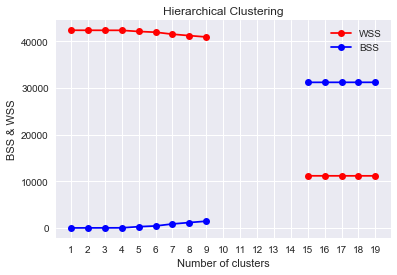

In [51]:
fig = plt.figure()
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');

In [53]:
wss_values

[42411.311837909168,
 42405.286120228629,
 42397.399270151684,
 42393.085932432041,
 42145.405455873144,
 41990.006311279205,
 41562.147982398594,
 41255.111385111741,
 40968.806936161018,
 nan,
 nan,
 nan,
 nan,
 nan,
 11178.497024203916,
 11175.358363890979,
 11174.024335725046,
 11172.397650611645,
 11171.50006305396]

In [46]:
#yp = KMeans(n_clusters=10).fit_predict(x)

In [47]:
def KneeElbowAnalysis(x,max_k=10):
    k_values = range(1,max_k)
    clusterings = [KMeans(n_clusters=k, random_state=12334).fit(x) for k in k_values]
    centroids_k = [clustering.cluster_centers_ for clustering in clusterings]

    D_k = [cdist(x, cent, 'euclidean') for cent in centroids_k]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/x.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]

    tss = sum(pdist(x)**2)/x.shape[0]
    bss = tss-wcss

    kIdx = 10-1
    
    #
    # elbow curve
    #
    fig = plt.figure()
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.plot(k_values, wcss, 'bo-', color='red', label='WCSS')
    plt.plot(k_values, bss, 'bo-', color='blue', label='BCSS')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.legend()
    plt.title('Knee for KMeans clustering');



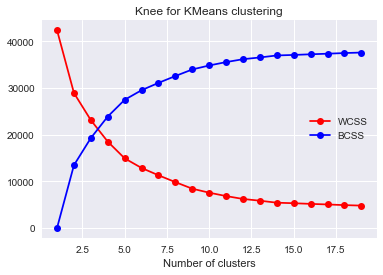

In [48]:
KneeElbowAnalysis(x,20)